<a href="https://colab.research.google.com/github/dssg/mlforpublicpolicylab/blob/master/techhelp/visualize_timechops_example_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install triage

In [ ]:
from triage.component.timechop.plotting import visualize_chops
from triage.component.timechop import Timechop
import matplotlib
matplotlib.use('Agg')
import matplotlib.dates as md
import numpy as np
from triage.util.conf import convert_str_to_relativedelta
import matplotlib.pyplot as plt
import yaml
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import datetime
%matplotlib inline
import yaml

In [ ]:
def visualize_chops_plotly(chopper, selected_splits=None, show_label_timespans=True, show_boxes=True, show_annotations=True):
    """Visualize time chops of a given Timechop object using plotly

    Args:
        chopper (triage.component.timechop.Timechop): A fully-configured Timechop object
        selected_splits (list): Indices of train-val sets to plot. E.g. [0, 1, 2] plots the 3 most recent splits, [0,-1] plots the first and last splits.
            Defaults to None, which plots all splits.
        show_label_timespans (bool): Whether or not to draw horizontal lines to show label timespan
            for as-of-times
        show_boxes (bool): Whether or not to show a rectangle highlighting train-test matrices
        show_annotations (bool): Whether or not to add annotations on the latest split, showing what each of the timechop parameters mean
    """
    chops = chopper.chop_time()
    chops.reverse() # reverse to get the most recent set first

    # Subset to relevant splits if arg specified, and generate titles for each split
    if selected_splits is not None:
      chops = [chops[i] for i in selected_splits]
      titles = tuple(f"Train-Validation Split {i+1}" for i in selected_splits)
    else:
      titles = tuple(f"Train-Validation Split {i+1}" for i in range(len(chops)))

    fig = make_subplots(rows=len(chops),
                        cols=1,
                        shared_xaxes=True,
                        shared_yaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=titles) # adds titles for each subplot

    # For each train-val split
    for idx, chop in enumerate(chops):
        train_as_of_times = chop["train_matrix"]["as_of_times"]
        test_as_of_times = chop["test_matrices"][0]["as_of_times"]

        test_label_timespan = chop["test_matrices"][0]["test_label_timespan"]
        training_label_timespan = chop["train_matrix"]["training_label_timespan"]

        # Colors for train/test
        train_color = "rgba(3, 37, 126" # dark blue (left open because we add an opacity argument below)
        test_color = "rgba(139, 0, 0" # magenta (left open because we add an opacity argument below)
        as_of_date_marker_opacity = ', 1)' # the extra ', 1)' defines opacity. 100% solid for markers
        label_line_opacity = ', 0.3)' # 30% opacity for the label lines
        rectangle_fill_opacity = ', 0.15)' # 15% opacity for rectangle fill

        train_as_of_date_color = train_color + as_of_date_marker_opacity
        train_label_period_color = train_color + label_line_opacity
        train_rectangle_fill = train_color + rectangle_fill_opacity
        test_as_of_date_color = test_color + as_of_date_marker_opacity
        test_label_period_color = test_color + label_line_opacity
        test_rectangle_fill = test_color + rectangle_fill_opacity

        # Show legend only if idx = 0 (i.e. first train-val set we are displaying)
        if idx == 0:
          # Train set as-of-date markers
          fig.add_trace(
              go.Scatter(x=[x.date() for x in train_as_of_times],
                        y=[x for x in range(len(train_as_of_times))],
                        mode='markers',
                        marker=dict(color=train_as_of_date_color),
                        name='Training as-of-date',
                        showlegend=True,
                        hovertemplate="%{x}<extra></extra>" # the extra extra tag gets rid of a default 'trace' line in the hover output and just shows 'x', the date
                        ),
              row=idx+1, # row and column of the subplots to add this trace object to
              col=1
              )
          # Validation set as-of-date markers
          fig.add_trace(
            go.Scatter(x=[x for x in test_as_of_times],
                      y=[x for x in range(len(test_as_of_times))],
                      mode='markers',
                      name='Validation as-of-date',
                      showlegend=True,
                      marker=dict(color=test_as_of_date_color),
                      hovertemplate="%{x}<extra></extra>"),
            row=idx+1,
            col=1
            )
        # Suppress legend if not the first subplot; only difference with above is showlegend=False (note, anytime we add a trace, we have to set showlegend=False to suppress useless info in the legend)
        else:
          # Train set as-of-date markers
          fig.add_trace(
              go.Scatter(x=[x.date() for x in train_as_of_times],
                        y=[x for x in range(len(train_as_of_times))],
                        mode='markers',
                        marker=dict(color=train_as_of_date_color),
                        name='Training as-of-date',
                        showlegend=False,
                        hovertemplate="%{x}<extra></extra>" # the extra extra tag gets rid of a default 'trace' line in the hover output and just shows 'x', the date
                        ),
              row=idx+1, # row and column of the subplots to add this trace object to
              col=1
              )

          # Validation set as-of-date markers
          fig.add_trace(
            go.Scatter(x=[x for x in test_as_of_times],
                      y=[x for x in range(len(test_as_of_times))],
                      mode='markers',
                      name='Validation as-of-date',
                      showlegend=False,
                      marker=dict(color=test_as_of_date_color),
                      hovertemplate="%{x}<extra></extra>"),
            row=idx+1,
            col=1
            )


        # Add test_durations annotation if option selected
        if idx == 0 and show_annotations==True:

          # Add a dashed line to show test_durations span
          x0 = test_as_of_times[0]
          x1 = test_as_of_times[-1]
          x_mid = x0 + (x1-x0)/2
          y = -1 # place the test durations labeling below the graph
          fig.add_shape(type='line', x0=x0, x1=x1, y0=y, y1=y, line={'color': 'green'}, row=idx+1, col=1)
          fig.add_annotation(x=x_mid, y=y-1, text=f"Test duration: {chop['test_matrices'][0]['test_duration']}", showarrow=False)

        # Add label timespan lines if option selected
        if show_label_timespans is True:

          # For training as_of_dates
          for i in range(len(train_as_of_times)):
            fig.add_trace(
                go.Scatter(
                    x=[train_as_of_times[i].date(), train_as_of_times[i].date() + convert_str_to_relativedelta(training_label_timespan)],
                    y=[i,i],
                    marker=dict(color=train_label_period_color, line=dict(color=train_label_period_color)),
                    hovertemplate="%{x}<extra></extra>",
                    showlegend=False
                ),
              row=idx+1,
              col=1
            )

            # Add annotation showing train label timespan on first bar in first train-val set (if option specified)
            if i == len(train_as_of_times)-1 and idx == 0 and show_annotations==True:

              # Have the x in between the label timespan
              x0 = train_as_of_times[i].date()
              x1 = train_as_of_times[i].date() + convert_str_to_relativedelta(training_label_timespan)
              x_pos = x0 + (x1 - x0)/2

              # Position at a y-value above the bar
              y_pos = i
              fig.add_annotation(x=x_pos, y=y_pos, text='Label timespan', showarrow=True, arrowhead=1, row=idx+1, col=1)

          # For test as_of_dates
          for i in range(len(test_as_of_times)):
            fig.add_trace(
                go.Scatter(
                    x=[test_as_of_times[i].date(), test_as_of_times[i].date() + convert_str_to_relativedelta(test_label_timespan)],
                    y=[i,i],
                    marker=dict(color= test_label_period_color, line=dict(color= test_label_period_color)),
                    showlegend=False,
                    hovertemplate="%{x}<extra></extra>"),
              row=idx+1,
              col=1
            )

            # Add annotation showing test label timespan on first bar in first train-val set (if option specified)
            if i == len(test_as_of_times)-1 and idx == 0 and show_annotations==True:

                # Have the x in between the label timespan
                x0 = test_as_of_times[i].date()
                x1 = test_as_of_times[i].date() + convert_str_to_relativedelta(test_label_timespan)
                x_pos = x0 + (x1 - x0)/2

                # Position at a y-value above the bar
                y_pos = i
                fig.add_annotation(x=x_pos, y=y_pos, text='Label timespan', showarrow=True, arrowhead=1, row=idx+1, col=1)

        # Add rectangles/boxes to mark train-test matrices
        if show_boxes is True:

          # Training matrix rectangle
          # Rectangle params
          x0 = min(train_as_of_times).date()
          x1 = max(train_as_of_times).date() + convert_str_to_relativedelta(training_label_timespan)
          y = max(len(test_as_of_times), len(train_as_of_times))

          fig.add_trace(
              go.Scatter(x =[x0,x0,x1,x1,x0], y=[0,y,y,0,0],
                        fill='toself', fillcolor=train_rectangle_fill,
                        showlegend=False,
                        marker=dict(color='rgba(0,255,0,0)', line=dict(color='rgba(0,255,0,0)')), # setting 0 opacity so we don't see the lines or markers
                        hoverinfo='skip'),
              row=idx+1,
              col=1,
          )

          # #Add annotated text to the middle of the training set rectangle -> this code works, but the positioning is a bit weird, so need to tweak
          # middle_index = round(len(train_as_of_times)/2)
          # x_middle = train_as_of_times[middle_index].date() + convert_str_to_relativedelta(training_label_timespan)
          # fig.add_trace(
          #     go.Scatter(x =[x_middle], y=[y-1],
          #               mode='text',
          #               text="Training Data",
          #               marker=dict(color='rgba(0,255,0,0)', line=dict(color='rgba(0,255,0,0)')), # setting 0 opacity so we don't see the lines
          #               hoverinfo='skip'),
          #     row=idx+1,
          #     col=1,
          # )

          # Test set rectangle

          # Rectangle params
          x0 = min(test_as_of_times).date()
          x1 = max(test_as_of_times).date() + convert_str_to_relativedelta(test_label_timespan)
          y = max(len(test_as_of_times), len(train_as_of_times))

          fig.add_trace(
              go.Scatter(x =[x0,x0,x1,x1,x0], y=[0,y,y,0,0],
                        fill='toself', fillcolor=test_rectangle_fill,
                        showlegend=False,
                        marker=dict(color='rgba(0,255,0,0)', line=dict(color='rgba(0,255,0,0)')), # setting 0 opacity so we don't see the lines
                        hoverinfo='skip'),
              row=idx+1,
              col=1,
          )

          # #Add annotated text to the test set rectangle
          # middle_index = round(len(test_as_of_times)/2)
          # x_middle = test_as_of_times[middle_index].date() + convert_str_to_relativedelta(test_label_timespan)
          # fig.add_trace(
          #     go.Scatter(x =[x_middle], y=[y-1],
          #               mode='text',
          #               text="Test Data",
          #               marker=dict(color='rgba(0,255,0,0)', line=dict(color='rgba(0,255,0,0)')), # setting 0 opacity so we don't see the lines
          #               hoverinfo='skip'),
          #     row=idx+1,
          #     col=1,
          # )

    fig.update_layout(height=500, width=900, showlegend=True)
    fig.show()

In [ ]:
cfg = """
temporal_config:

    # first date our feature data is good
    feature_start_time: '2012-01-01'
    feature_end_time: '2023-01-01'

    # first date our label data is good
    # donorschoose: as far back as we have good donation data
    label_start_time: '2019-01-01'
    label_end_time: '2023-01-01'

    model_update_frequency: '3month'

    # length of time defining a test set
    test_durations: ['1month']
    # defines how far back a training set reaches
    max_training_histories: ['100year']

    # we sample every day, since new projects are posted
    # every day
    training_as_of_date_frequencies: ['1month']
    test_as_of_date_frequencies: ['1month']

    # like our project timeout
    training_label_timespans: ['1year']
    test_label_timespans: ['1year']
"""

In [ ]:
c = yaml.safe_load(cfg)
chopper = Timechop(**c['temporal_config'])
# artifically set the feature_start_time to the label_start_time to zoom in on the train/validation splits
chopper.feature_start_time = chopper.label_start_time

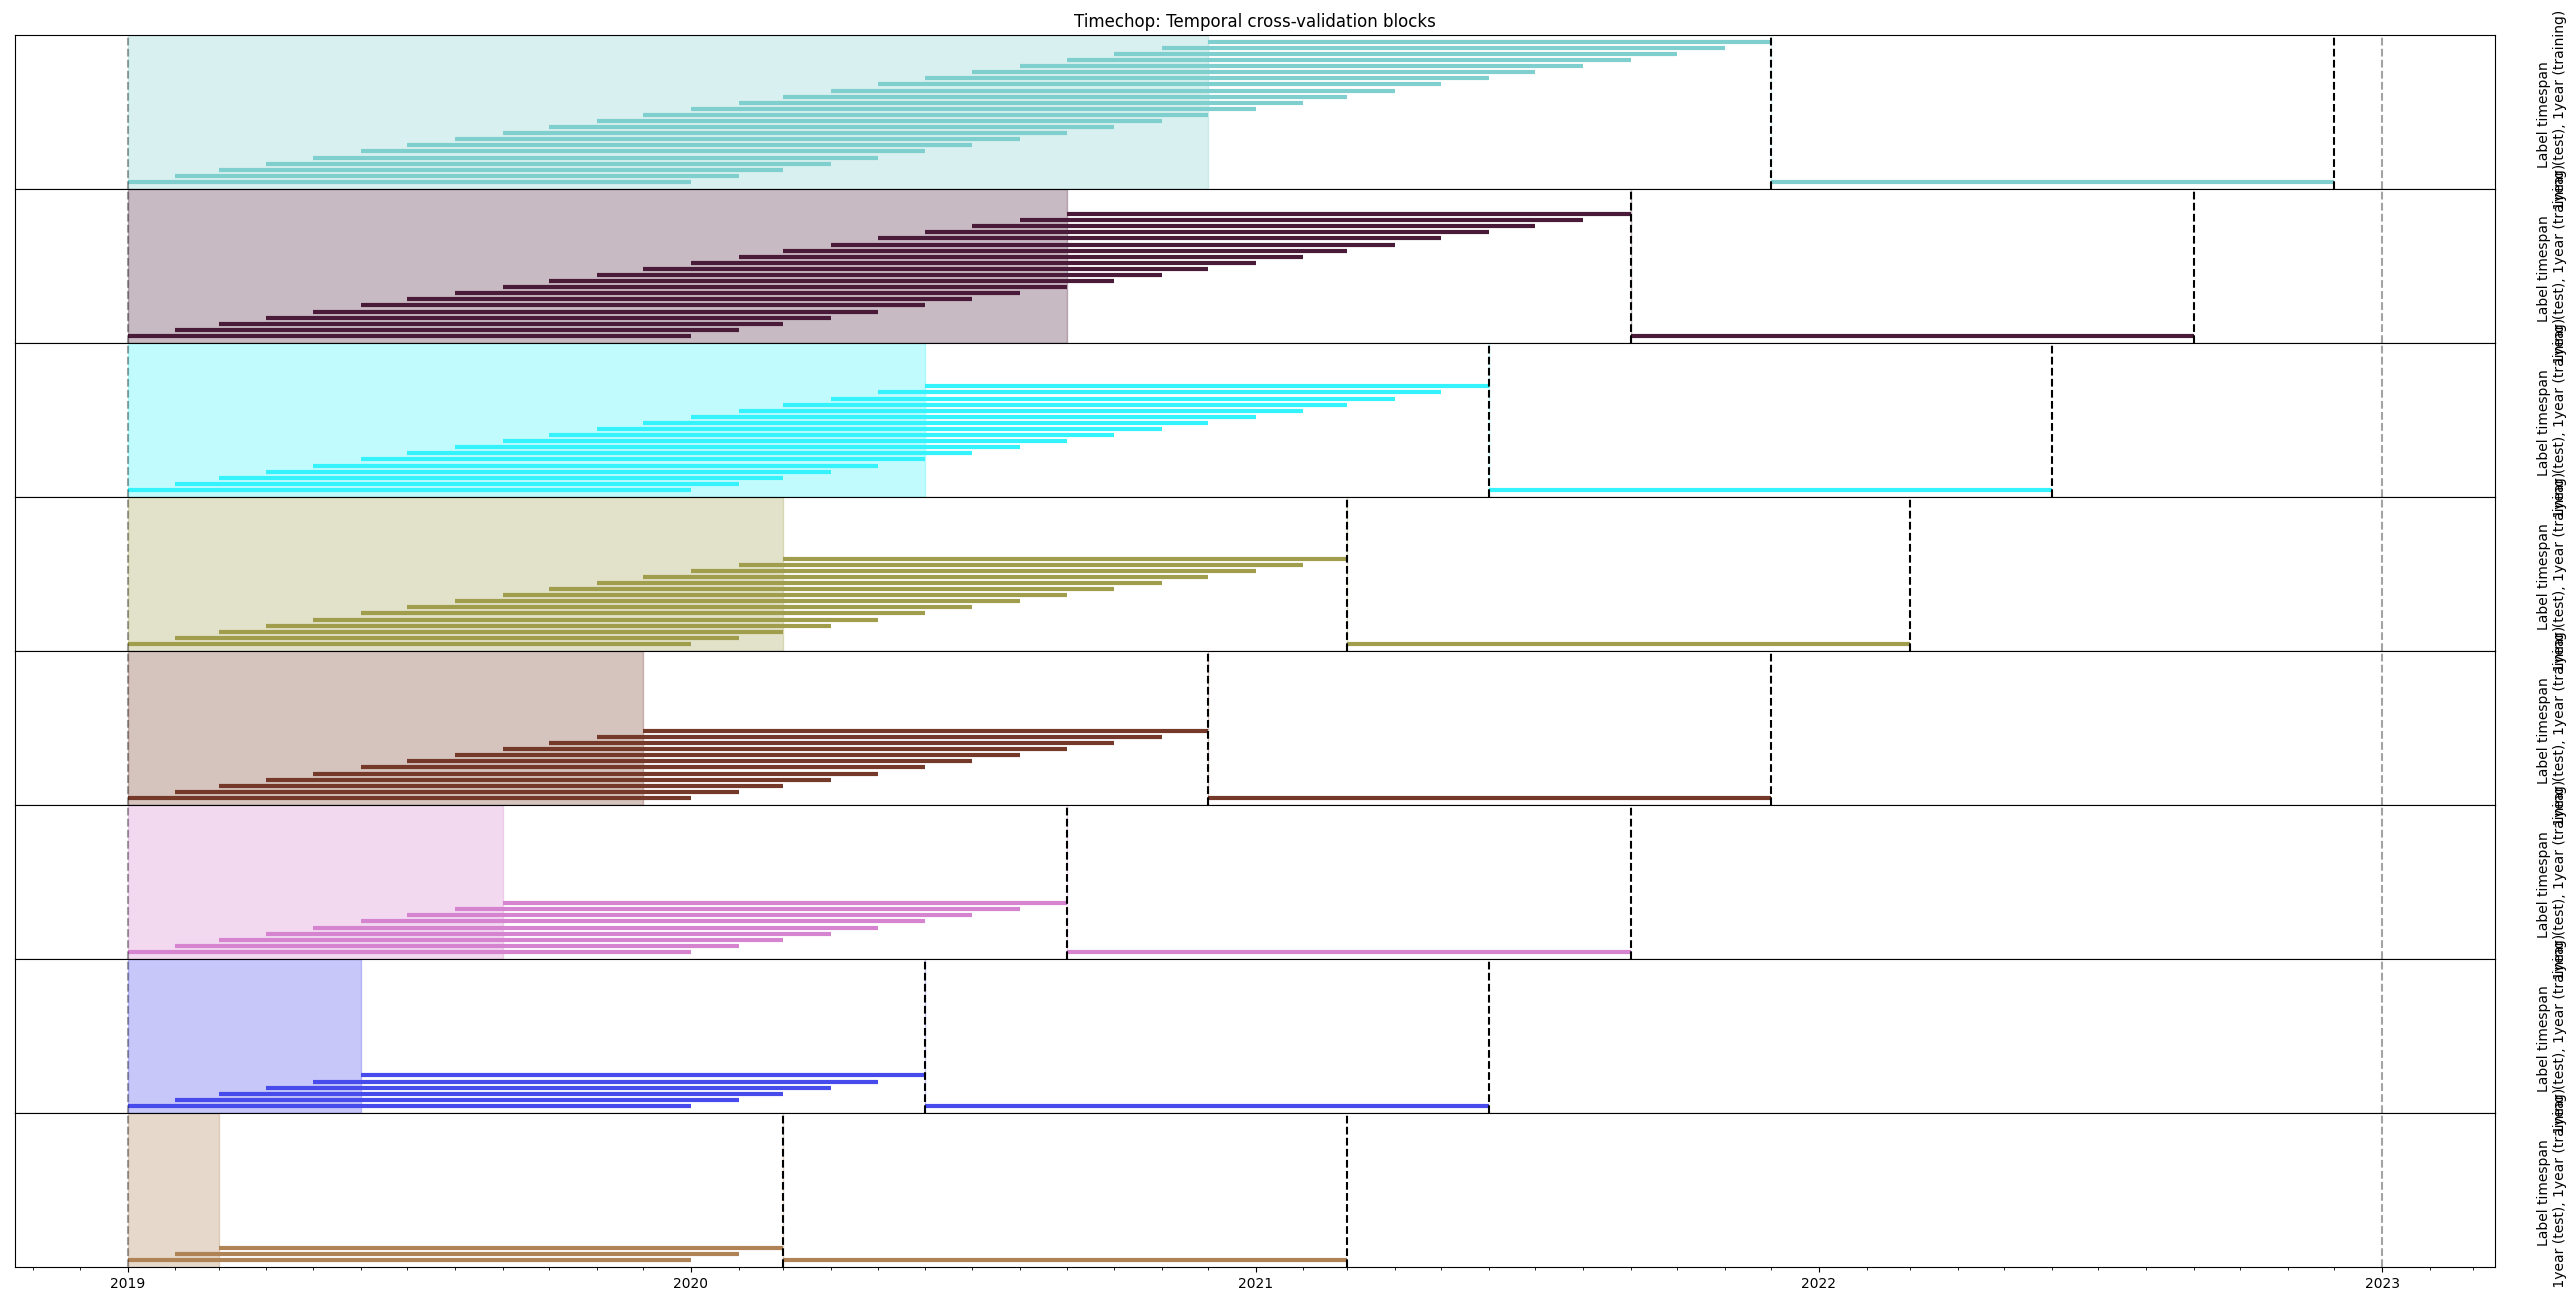

In [18]:
visualize_chops(chopper)

In [19]:
visualize_chops_plotly(chopper, selected_splits = [0, 1, 2],show_label_timespans=True, show_boxes=True, show_annotations=True)